# Import and Global Variables

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q git+http://github.com/tensorflow/examples.git
# use in improting pix2pix

  Preparing metadata (setup.py) ... done


In [ ]:
%cd /content/drive/MyDrive/ObjectDetection/

/content/drive/MyDrive/ObjectDetection


In [ ]:
!unzip Images -d Data
!unzip Labels -d Data

In [ ]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# Load DAta

In [ ]:
images_path='/content/drive/MyDrive/ObjectDetection/Data/Images'
masks_path='/content/drive/MyDrive/ObjectDetection/Data/Labels'

In [ ]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [ ]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [ ]:
# If they are not same image name in mask and images path this cell will be run
images_paths.sort()
masks_paths.sort()

In [ ]:

print(images_paths[:5]) # it is improtatnt that the mask and image have same number name

['/content/drive/MyDrive/ObjectDetection/Data/Images/image_day_0.png', '/content/drive/MyDrive/ObjectDetection/Data/Images/image_day_1.png', '/content/drive/MyDrive/ObjectDetection/Data/Images/image_day_10.png', '/content/drive/MyDrive/ObjectDetection/Data/Images/image_day_100.png', '/content/drive/MyDrive/ObjectDetection/Data/Images/image_day_101.png']


In [ ]:
print(masks_paths[:5])

['/content/drive/MyDrive/ObjectDetection/Data/Labels/image_day_0.png', '/content/drive/MyDrive/ObjectDetection/Data/Labels/image_day_1.png', '/content/drive/MyDrive/ObjectDetection/Data/Labels/image_day_10.png', '/content/drive/MyDrive/ObjectDetection/Data/Labels/image_day_100.png', '/content/drive/MyDrive/ObjectDetection/Data/Labels/image_day_101.png']


In [ ]:
# codes for replaceeing
def replace_values(value):
    value_mapping = {30: 0, 110: 1, 215: 2}
    return value_mapping.get(value, value)

#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = preprocessing(img)
  train_images.append(img)


for maskpath in tqdm.tqdm(masks_paths):
  mask0 = cv2.imread(maskpath, 0)
  vectorized_replace = np.vectorize(replace_values)
  mask0 = vectorized_replace(mask0)
  mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.10, shuffle=True, random_state = 1)
print("Class values: ", np.unique(y_train))

100%|██████████| 365/365 [02:00<00:00,  3.03it/s]


Class values:  [0 1 2]


In [ ]:
import keras

base=keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False,weights="imagenet")
keras.utils.plot_model(base,show_shapes=True)

In [ ]:
# this code is usded to convert mask to [0,1,2]
import numpy as np

original_array = y_train[1]

# Create a mapping function
def replace_values(value):
    value_mapping = {30: 0, 110: 1, 215: 2}
    return value_mapping.get(value, value)

# Use vectorize to apply the replacement function to each element in the array
vectorized_replace = np.vectorize(replace_values)
new_array = vectorized_replace(original_array)

print("Class values: ", np.unique(new_array))
print("Class values: ", np.unique(original_array))


Class values:  [0 1 2]
Class values:  [ 30 110 215]


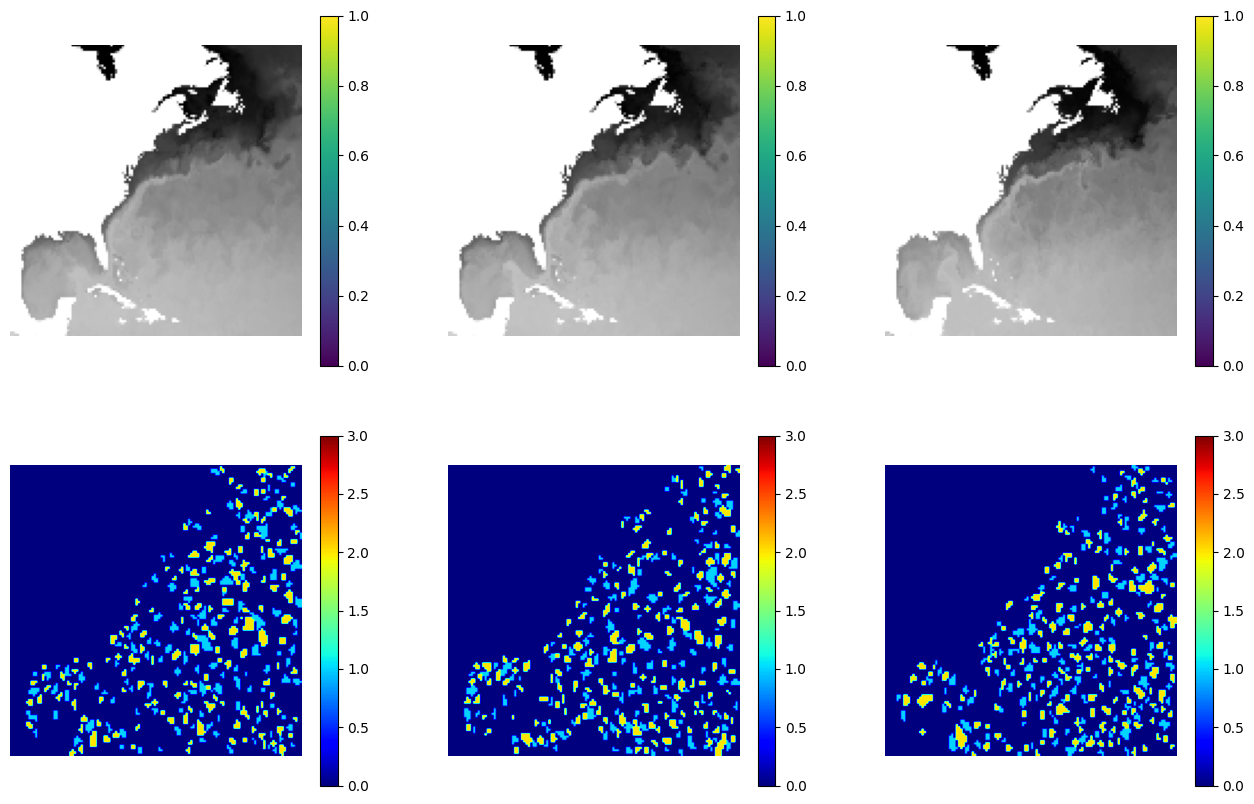

In [ ]:
NORM = mpl.colors.Normalize(vmin=0, vmax=3)

plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

## Define Unet based on mobilenet V2 as `backbones`

1.   List item
2.   List item



In [ ]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CHANNELS=3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])   #



9406464/9406464 [==============================] - 0s 0us/step


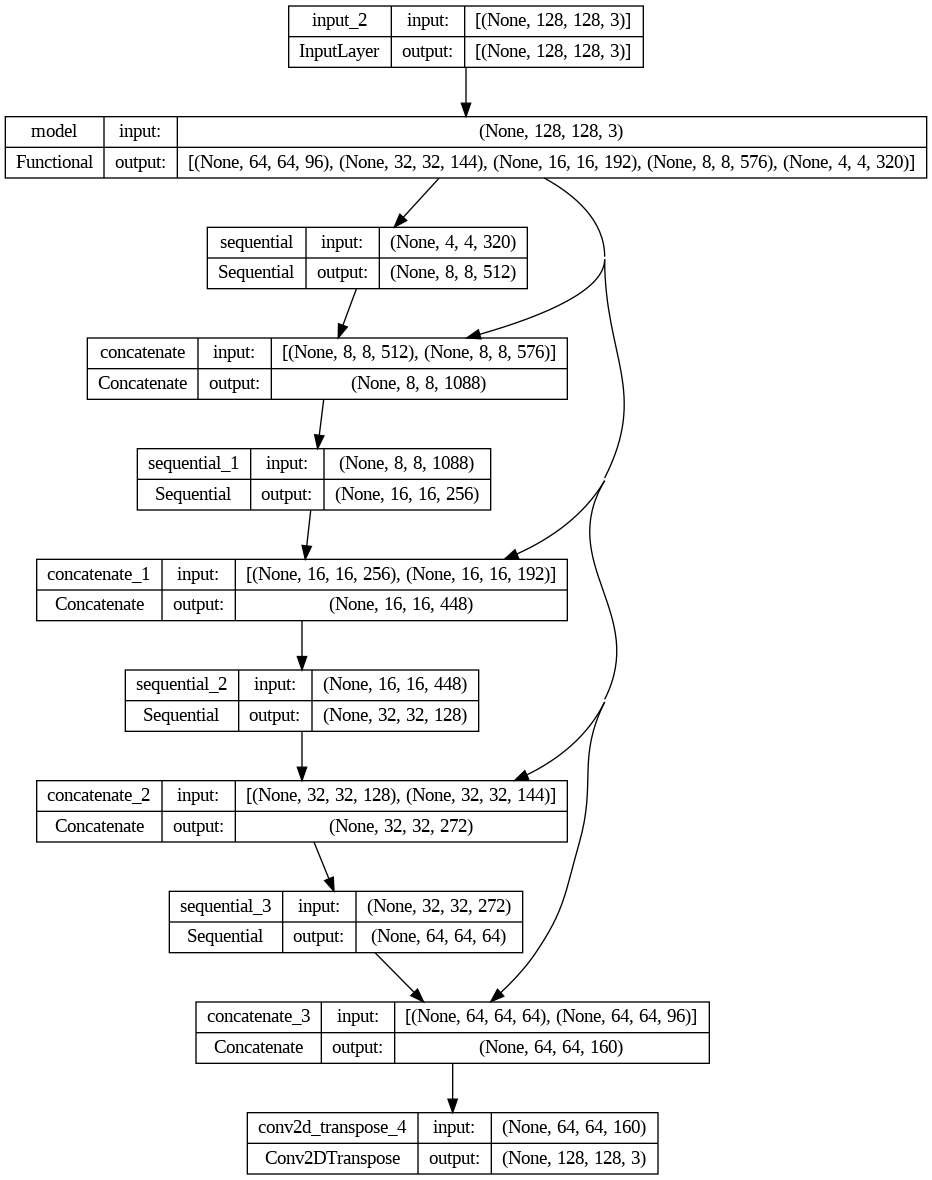

In [ ]:
import keras

keras.utils.plot_model(model,show_shapes=True)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 96),         1841984   ['input_2[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=50):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(ii)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

# Train Models

In [ ]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BATCH_SIZE = 16
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# sample_image = train_images[0]
# sample_mask = train_masks[0]

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_history = model.fit(X_train, y_train, epochs=EPOCHS,
                           batch_size = BATCH_SIZE,
                          verbose=1,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=(X_val, y_val),
                          callbacks=[DisplayCallback()]
                          )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save('./models/MobileNetV2')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 96),         1841984   ['input_4[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [ ]:
import keras
model2=keras.saving.load_model('./models/ObjectDetectionv2')

## Visualize Results

In [ ]:
test_path = "/content/drive/MyDrive/ObjectDetection/Data/TestImages"

test_paths = []

for imgname in os.listdir(test_path):
  test_paths.append(os.path.join(test_path,imgname))

1/1 [==============================] - 0s 24ms/step


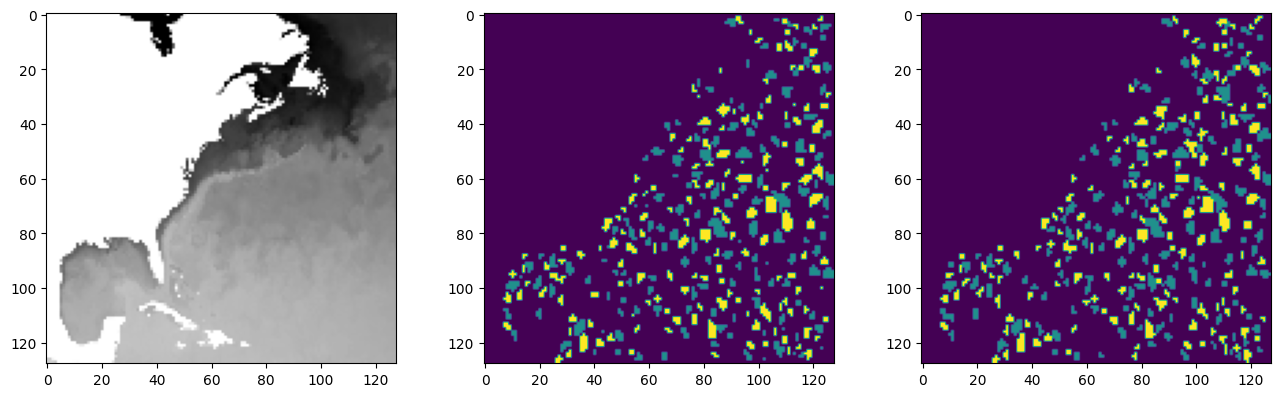

In [ ]:
test_path = "/content/drive/MyDrive/ObjectDetection/Data/TestImages"
timgnum = 0
img_num = int(test_paths[timgnum].split("/")[-1].split(".")[0].split("_")[-1])

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
img = cv2.imread(test_paths[timgnum])
img = cv2.resize(img, (SIZE_Y, SIZE_X))
img = preprocessing(img)
plt.imshow(img)

plt.subplot(2,3,2)
pred = np.array(create_mask(model.predict(img[tf.newaxis, ...])))
plt.imshow(np.squeeze(pred))

plt.subplot(2,3,3)
plt.imshow(train_masks[img_num-1])

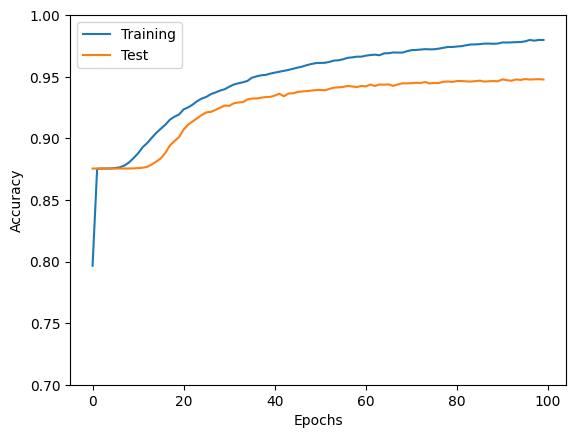

In [ ]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']



plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


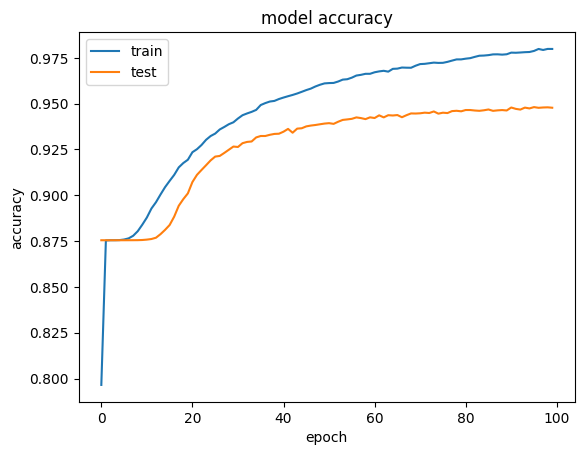

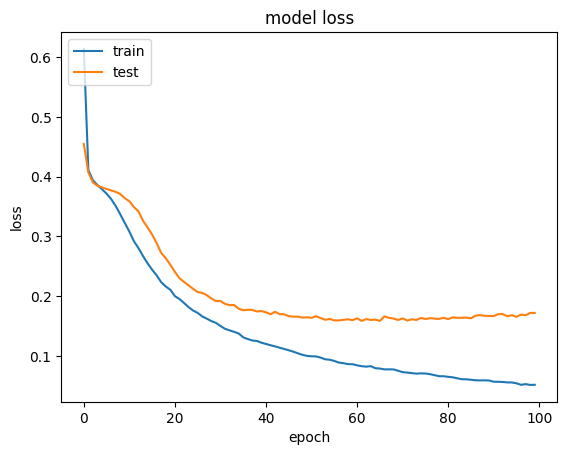

In [ ]:
history=model_history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visulize F1Score- precison Recall

In [ ]:
images_paths
masks_paths


365


In [ ]:
import numpy as np
gt_masks=masks_paths
def calculate_metrics(gt_mask, pred_mask):
    # Flatten the masks
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()

    # Calculate True Positive, False Positive, and False Negative
    TP = np.sum((gt_flat == 1) & (pred_flat == 1))
    FP = np.sum((gt_flat == 0) & (pred_flat == 1))
    FN = np.sum((gt_flat == 1) & (pred_flat == 0))

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1_score

# Example usage
# Assuming gt_masks and pred_masks are arrays containing ground truth and predicted masks for all images
# You would iterate over each pair of masks and accumulate metrics
total_precision = 0
total_recall = 0
total_f1_score = 0


for test_img_number in range(len(train_images)):

  test_img = train_images[test_img_number]
  img_mask = train_masks[test_img_number]

  predicted_img = np.squeeze(create_mask(model.predict(train_images[test_img_number][tf.newaxis, ...])).numpy())
  precision, recall, f1_score = calculate_metrics(train_masks[test_img_number], predicted_img)
  total_precision += precision
  total_recall += recall
  total_f1_score += f1_score




# Calculate average metrics over all images
average_precision = total_precision / len(gt_masks)
average_recall = total_recall / len(gt_masks)
average_f1_score = total_f1_score / len(gt_masks)

print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")


1/1 [==============================] - 0s 32ms/step
Average Precision: 0.9137062051600575
Average Recall: 0.9001080372240792
Average F1 Score: 0.9067192568120185


# dice score and iou can be reported here

In [ ]:
# https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/

In [ ]:
import tensorflow as tf

m = tf.keras.metrics.MeanIoU(num_classes=3)

In [ ]:
import tensorflow.keras.backend as K

def dice_coef1(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #print(tf.reduce_sum(y_true_f).numpy(), tf.reduce_sum(y_pred_f).numpy())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



In [ ]:
# Dice Scores for segmentation
n_classes=3
dfs = {}
for i in range(n_classes):
  dfs[i]=[]

for test_img_number in range(len(train_images)):

  test_img = train_images[test_img_number]
  img_mask = train_masks[test_img_number]

  predicted_img = np.squeeze(create_mask(model.predict(train_images[test_img_number][tf.newaxis, ...])).numpy())

  img_mask_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
  img_pred_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
  for i in range(n_classes):
    #print(test_img_number, i)
    img_mask_exp[:,:,i][img_mask==i]=1
    img_pred_exp[:,:,i][predicted_img==i]=1
    df = dice_coef1(img_mask_exp[:,:,i], img_pred_exp[:,:,i]).numpy()
    dfs[i].append(df)

dfss = []
for i in range(n_classes):
  avg = sum(dfs[i]) / len(dfs[i])
  print(f"Dice score of {str(i)}: {str(avg)}")
  dfss.append(avg)

1/1 [==============================] - 0s 31ms/step
Dice score of 0: 0.9873166697212418
Dice score of 1: 0.9066654542269489
Dice score of 2: 0.911154881897142


In [ ]:
def iou(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
import tensorflow as tf

def iou(y_true, y_pred, smooth=1e-6):
    ndims = len(y_true.shape)

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=list(range(1, ndims)))
    union = tf.reduce_sum(y_true, axis=list(range(1, ndims))) + tf.reduce_sum(y_pred, axis=list(range(1, ndims))) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Rest of the code remains the same

# Rest of the code remains the same


# Assuming train_images and train_masks are lists or arrays of images and masks
n_classes = 3
ious = {i: [] for i in range(n_classes)}

for test_img_number in range(len(train_images)):
    test_img = train_images[test_img_number]
    img_mask = train_masks[test_img_number]

    predicted_img = np.squeeze(create_mask(model.predict(test_img[tf.newaxis, ...])).numpy())

    img_mask_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
    img_pred_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))

    for i in range(n_classes):
        img_mask_exp[:, :, i][img_mask == i] = 1
        img_pred_exp[:, :, i][predicted_img == i] = 1
        iou_score = iou(img_mask_exp[:, :, i], img_pred_exp[:, :, i]).numpy()
        ious[i].append(iou_score)

iou_scores = []
for i in range(n_classes):
    avg_iou = sum(ious[i]) / len(ious[i])
    print(f"IoU score of class {i}: {avg_iou}")
    iou_scores.append(avg_iou)


1/1 [==============================] - 0s 21ms/step
IoU score of class 0: 0.9744656946972962
IoU score of class 1: 0.8044666801518121
IoU score of class 2: 0.8114982938220134
